<a href="https://colab.research.google.com/github/taguch1s/study/blob/main/nlp_using_scikitlean_tensorflow/06_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using Logistic Regression

## Setup

In [ ]:
!pip install janome beautifulsoup4

     |████████████████████████████████| 19.7MB 1.7MB/s 


## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from bs4 import BeautifulSoup
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, GridSearchCV, ShuffleSplit

## The dataset

今回は、データセットとして[Amazon Customer Reviews Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)を使います。このデータセットは、Amazonの製品レビューにメタデータを付与して作成されたコーパスです。データの中に評価（1-5）が含まれているため、テキスト分類モデルの学習に使うことができます。

今回は以下の設定で使うことにします。

- Number of labels: 2.
- Size of training dataset: 8000.
- Size of evaluation dataset: 2000.
- Language: Japanese

### Load the Amazon Customer Reviews Datasets

In [ ]:
def filter_by_ascii_rate(text, threshold=0.9):
    ascii_letters = set(string.printable)
    rate = sum(c in ascii_letters for c in text) / len(text)
    return rate <= threshold


def load_dataset(filename, n=5000, state=6):
    df = pd.read_csv(filename, sep='\t')

    # Converts multi-class to binary-class.
    mapping = {1: 0, 2: 0, 4: 1, 5: 1}
    df = df[df.star_rating != 3]
    df.star_rating = df.star_rating.map(mapping)

    # extracts Japanese texts.
    is_jp = df.review_body.apply(filter_by_ascii_rate)
    df = df[is_jp]

    # sampling.
    df = df.sample(frac=1, random_state=state)  # shuffle
    grouped = df.groupby('star_rating')
    df = grouped.head(n=n)

    return df.review_body.values, df.star_rating.values


url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_JP_v1_00.tsv.gz'
x, y = load_dataset(url, n=5000)

In [ ]:
x[0]

'現在、地球温暖化の悪影響が、ここまで顕在化しているとは<br />想像していませんでした。特に、このまま海面温度が上昇を<br />続けると、早晩、南極・北極の氷が大規模に溶けることに<br />よって相当の範囲の陸地が海に没し、十億人単位での難民が<br />発生するという事実には、本当に衝撃を受けました。<br /><br />ある人が、「人間は地球にすくう癌細胞のようである。<br />増殖・破壊を続け、最終的には自らも寄生先の死によって<br />滅ぶ運命にある」と言っていたことを思い出しました。<br /><br />一方、主人公であるゴア氏が、聴衆が数十人〜数百人程度の<br />世界中の教室・会議場をまわって危機を訴えるという、地道<br />な「草の根」の活動にも大変感銘を受けました。個人的には、<br />ゴア氏には、ブッシュ氏との大統領戦における、「賢いが<br />傲慢で冷徹」というイメージが強かったのですが、およそ<br />そんなことはない（＝きっと、ブッシュ陣営のネガティブ・<br />キャンペーンの影響を愚かにも受けていたのでしょう）、<br />信念を持ち、実行力が伴った、特筆すべき政治家であること<br />も分かりました。<br /><br />温暖化の危機、ゴア氏ほかの活動家・学者の行動に対する<br />不明を恥じると共に、自らもCO2ゼロ化に向けて早速行動<br />したいと思いました。<br /><br />なお、当作品は、語られる事象のすべてが具体的かつ<br />客観的に科学的根拠に支えられており、ドキュメンタリー<br />としても秀逸だと思います。<br /><br />是非ご覧になってみて下さい。お奨めします。'

### Preprocess the dataset

In [ ]:
t = Tokenizer(wakati=True)


def tokenize(text):
    return t.tokenize(text)


def clean_html(html, strip=False):
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text(strip=strip)
    return text

In [ ]:
x = [clean_html(text, strip=True) for text in x]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(tokenizer=tokenize)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

## Experiments

### Cross Validation

In [ ]:
clf = LogisticRegression(solver='liblinear')
scores = cross_val_score(clf, x_train_vec, y_train, cv=5)
print(scores)
print('Accuracy: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std() * 2))

clf.fit(x_train_vec, y_train)
y_pred = clf.predict(x_test_vec)
score = accuracy_score(y_test, y_pred)
print('Accuracy(test): {:.4f}'.format(score))

[0.8175   0.83375  0.8225   0.8275   0.820625]
Accuracy: 0.8244 (+/- 0.0114)
Accuracy(test): 0.8440


### Draw Learning Curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')

    plt.show()

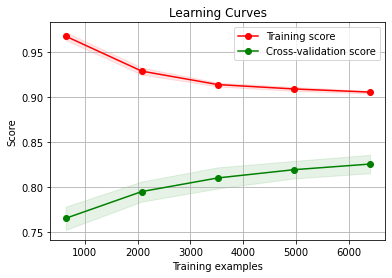

In [ ]:
title = 'Learning Curves'
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
clf = LogisticRegression(solver='liblinear')
plot_learning_curve(clf, title, x_train_vec, y_train, cv=cv)

### Hyper-parameter Optimization

In [ ]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.03, 0.1, 0.3, 0.7, 1, 1.01, 1.03, 1.07, 1.1, 1.3, 1.7, 3]
}
lr = LogisticRegression(solver='liblinear')
clf = GridSearchCV(lr, parameters, cv=5, n_jobs=-1)
clf.fit(x_train_vec, y_train)

best_clf = clf.best_estimator_
print(clf.best_params_)
print('Accuracy(best): {:.4f}'.format(clf.best_score_))
y_pred = best_clf.predict(x_test_vec)
score = accuracy_score(y_test, y_pred)
print('Accuracy(test): {:.4f}'.format(score))

{'C': 3, 'penalty': 'l2'}
Accuracy(best): 0.8331
Accuracy(test): 0.8540


### Visualize neg/pos features

おまけ: 学習した分類器の係数を基に、簡易的にですが、neg/posの分類に効いている特徴を可視化してみましょう。

In [ ]:
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(x_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
feature_coef = sorted(zip(clf.coef_[0], vectorizer.get_feature_names()))
num_features = 50

In [ ]:
neg_features = feature_coef[:num_features]
neg_features

[(-12.85161160768079, 'がっかり'),
 (-10.767219640668403, '残念'),
 (-10.051482807443334, '駄作'),
 (-9.695630454182789, '返品'),
 (-8.980254444217394, 'ない'),
 (-8.321718381558062, 'のに'),
 (-7.946590672965331, 'ひどい'),
 (-7.250056479532265, '評価'),
 (-7.009250111894679, 'ガッカリ'),
 (-6.675655754933128, '最悪'),
 (-6.667048593560964, 'ませ'),
 (-6.564962170234089, 'すぎ'),
 (-6.485715985229304, 'ダメ'),
 (-6.378969074273843, '悪い'),
 (-6.164071275617413, 'なかっ'),
 (-5.904022994139838, '退屈'),
 (-5.803137847608894, 'つまらない'),
 (-5.74750052058162, 'すぎる'),
 (-5.361098169022657, '中途半端'),
 (-5.098321804513297, '？'),
 (-4.938061657307268, 'レンタル'),
 (-4.876682307213126, '声優'),
 (-4.64820251172889, 'あまりに'),
 (-4.5288506617981765, '失敗'),
 (-4.521576323485976, '?'),
 (-4.310057958036719, 'なら'),
 (-4.10126929106065, 'しろ'),
 (-4.019336117382805, 'だけ'),
 (-3.939911068904153, '最低'),
 (-3.87793392872595, 'し'),
 (-3.7944923132697337, 'のみ'),
 (-3.7486859146097307, '途中'),
 (-3.682635483720624, '正直'),
 (-3.6477502156043258, 'ん'),


In [ ]:
pos_features = feature_coef[-num_features:][::-1]
pos_features

[(9.900107203144929, '満足'),
 (8.93011589211124, '是非'),
 (7.901564205120403, '最高'),
 (7.579076543725971, '素晴らしい'),
 (7.562440164777936, '傑作'),
 (6.0939586229532, '楽しめ'),
 (5.711942955546392, 'ます'),
 (5.531819117302129, 'できる'),
 (5.499660545447942, 'そして'),
 (5.468393115452372, 'とても'),
 (4.9887798588317835, '♪'),
 (4.727571887985393, 'やすい'),
 (4.348074946254973, 'くれる'),
 (4.336678632369818, '便利'),
 (4.290071526771762, '年'),
 (4.242239853750389, '見事'),
 (4.237096730197394, '聴い'),
 (4.078804543082052, '文句'),
 (4.033409665434966, 'ギター'),
 (4.011797566464488, 'いく'),
 (3.9441095478677335, '心'),
 (3.7817231404254947, 'こと'),
 (3.718373885142847, 'なかなか'),
 (3.673677875817371, 'も'),
 (3.491095442477997, '嬉しい'),
 (3.2327195921687784, '彼'),
 (3.168372309565237, '！'),
 (3.132579544522574, '楽しい'),
 (3.127637288606355, '頃'),
 (3.0706027837223346, '楽しめる'),
 (2.9750182780909724, 'ながら'),
 (2.9143115041191834, 'まさに'),
 (2.87753130195919, '時代'),
 (2.845953167451273, '強い'),
 (2.8117938619103735, '面白い'),
 (2.

neg/posの分類に効いている特徴を表示してみました。こうして可視化をすると、改善のための気付きを得るのに役立ちます。

neg/posの両方に「2つ/4つ」という単語が分類に効いていることがわかります。これは元は「星2つ」のような文だったと考えられます。認識性能を上げるためだけなら含めておいてもよいと思いますが、こうした評価そのものを表す単語を使って予測したくない場合は、前処理で取り除きましょう。他にも、ストップワードの除去やbigram, trigramが性能向上に効きそうだという仮説を立てることができます。

### Visualize feaatures using ELI5

おまけ: [ELI5](https://eli5.readthedocs.io/en/latest/)を使って特徴を可視化してみましょう。

In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 2.7MB/s 


In [ ]:
import eli5

In [ ]:
doc = x_test[0]
print(doc)
eli5.show_prediction(clf, doc, vec=vectorizer, target_names=['neg', 'pos'])

剛力の吹き替えが酷いですが、ALIEN好きならシリーズ全てコンプリートしておかないと　その為に購入しました。
